In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import glob
import itertools
import os
import random
from os import listdir
from os.path import isfile, join

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import tensorflow.keras.backend as K
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau)
from tensorflow.keras.layers import (
    Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, Input,
    LeakyReLU, MaxPool2D, SeparableConv2D)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
PATH = 'C:/Users/dmtry/Desktop/OCT2017'

In [4]:
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

In [5]:
batch_size = 24
epochs = 15
IMG_HEIGHT = 227
IMG_WIDTH = 227
model_name = 'mini_inception_GAP'

In [6]:
train_image_generator = ImageDataGenerator(rescale=1./255, validation_split = 0.2, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')  
test_image_generator = ImageDataGenerator(rescale=1./255)

In [7]:
train_data_gen = train_image_generator.flow_from_directory(batch_size = batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           color_mode='grayscale',
                                                           class_mode='sparse',
                                                           subset = 'training')
print()
val_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory = train_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              color_mode='grayscale',
                                                              class_mode='sparse',
                                                              subset = 'validation')
print()
test_data_gen = test_image_generator.flow_from_directory(batch_size = 1,
                                                              directory=test_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              color_mode='grayscale',
                                                              class_mode='sparse')

Found 66788 images belonging to 4 classes.

Found 16696 images belonging to 4 classes.

Found 968 images belonging to 4 classes.


In [8]:
input_tensor = Input(shape = (IMG_HEIGHT, IMG_WIDTH, 1))
#================================================================================================================
layer1_1 = layers.Conv2D(filters = 16, kernel_size = (1, 1), activation = 'relu')(input_tensor)
#227x227x16

layer1_2 = layers.Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same') (input_tensor)
#227x227x16

layer1_3 = layers.Conv2D(filters = 16, kernel_size = (5, 5), activation = 'relu', padding = 'same') (input_tensor)
#227x227x16

layer1 = layers.concatenate([layer1_1, layer1_2, layer1_3], axis = -1)
#227x227x48
#================================================================================================================
layer2_1 = layers.Conv2D(filters = 48, kernel_size = (1, 1), activation = 'relu')(layer1)
layer2_1 = layers.Conv2D(filters = 64, kernel_size = (7, 7), strides = 2, activation = 'relu')(layer2_1)
#111x111x64

layer2_2 = layers.Conv2D(filters = 48, kernel_size = (1, 1), activation = 'relu')(layer1)
#227x227x48
layer2_2 = layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu')(layer2_2) 
#225x225x64
layer2_2 = layers.Conv2D(filters = 64, kernel_size = (5, 5), activation = 'relu', strides = 2)(layer2_2)
#111x111x64 

layer2 = layers.concatenate([layer2_1, layer2_2], axis = -1)
#111x111x128
#================================================================================================================
layer3_1 = layers.Conv2D(filters = 128, kernel_size = (1, 1), activation = 'relu')(layer2)

layer3_2 = layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu')(layer2)

layer3_3 = layers.Conv2D(filters = 64, kernel_size = (5, 5), activation = 'relu', padding = 'same') (layer2)

layer3 = layers.concatenate([layer3_1, layer3_2, layer3_3], axis = -1)
#111x111x256
#================================================================================================================
layer4_1 = layers.Conv2D(filters = 96, kernel_size = (2, 2), activation = 'relu')(layer3)
layer4_1 = layers.MaxPool2D(pool_size = (2,2), strides = 2)(layer4_1)
#55x55x64
layer4_2 = layers.AveragePooling2D(pool_size = (2,2), strides = 2)(layer3)
#55x55x64
layer4_3 = layers.Conv2D(filters = 96, kernel_size = (3, 3), strides = 2, activation = 'relu')(layer3)
#55x55x64

layer4 = layers.concatenate([layer4_1, layer4_2, layer4_3], axis = -1)
#55x55x384
#================================================================================================================
layer5 = layers.SeparableConv2D(filters = 384, kernel_size = (3, 3), strides = 2, activation = 'relu')(layer4)
layer5 = layers.BatchNormalization()(layer5)
layer5 = layers.Dropout(0.2)(layer5)
#27x27x384
#================================================================================================================
layer6 = layers.SeparableConv2D(filters = 412, kernel_size = (3, 3), strides = 2, activation = 'relu')(layer5)
layer6 = layers.BatchNormalization()(layer6)
layer6 = layers.MaxPool2D()(layer6)
layer6 = layers.Dropout(0.2)(layer6)
#13x13x412
#================================================================================================================
layer7 = layers.SeparableConv2D(filters = 462, kernel_size = (3, 3), strides = 2, activation = 'relu')(layer6)
layer7 = layers.BatchNormalization()(layer7)
layer7 = layers.GlobalAveragePooling2D()(layer7)

#================================================================================================================
output = Flatten()(layer7)
out_2 = Dense(128, activation='relu')(output)
out = Dense(4, activation='softmax')(out_2)

In [9]:
model = Model(input_tensor, out)

In [10]:
callbacks_list = [ tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 2,verbose = 1),
tf.keras.callbacks.ModelCheckpoint( filepath = 'C:/Users/dmtry/Desktop/MODELS/' + model_name + '.h5', monitor='val_accuracy',save_best_only=True, mode = 'max', verbose = 1),
tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience = 1, verbose = 1)]

In [11]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train_data_gen.classes),
                                                  train_data_gen.classes)

In [12]:
model.compile(optimizer = 'rmsprop', loss ='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 227, 227, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 227, 227, 16) 32          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 227, 227, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 227, 227, 16) 416         input_1[0][0]                    
______________________________________________________________________________________________

In [14]:
hist = model.fit_generator(
    train_data_gen,
    steps_per_epoch = train_data_gen.samples // batch_size,
    epochs = epochs,
    validation_data = val_data_gen,
    validation_steps= val_data_gen.samples // batch_size,
    class_weight=class_weights,
    callbacks = callbacks_list)

Epoch 1/15
2781/2782 [============================>.] - ETA: 0s - loss: 0.8007 - accuracy: 0.7044
Epoch 00001: val_accuracy improved from -inf to 0.73058, saving model to C:/Users/dmtry/Desktop/MODELS/mini_inception_GAP.h5
2782/2782 [==============================] - 2119s 762ms/step - loss: 0.8006 - accuracy: 0.7045 - val_loss: 0.9717 - val_accuracy: 0.7306
Epoch 2/15
2781/2782 [============================>.] - ETA: 0s - loss: 0.5800 - accuracy: 0.7918
Epoch 00002: val_accuracy did not improve from 0.73058
2782/2782 [==============================] - 2051s 737ms/step - loss: 0.5801 - accuracy: 0.7918 - val_loss: 0.7224 - val_accuracy: 0.7248
Epoch 3/15
2781/2782 [============================>.] - ETA: 0s - loss: 0.4465 - accuracy: 0.8443
Epoch 00003: val_accuracy improved from 0.73058 to 0.86613, saving model to C:/Users/dmtry/Desktop/MODELS/mini_inception_GAP.h5
2782/2782 [==============================] - 2076s 746ms/step - loss: 0.4465 - accuracy: 0.8443 - val_loss: 0.4026 - val_a

# Графики

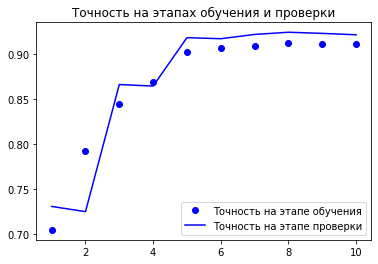

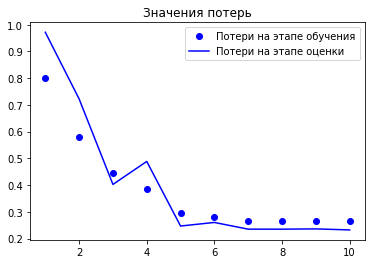

In [15]:
acc = hist.history['accuracy'] 
val_acc = hist.history['val_accuracy'] 
loss = hist.history['loss'] 
val_loss = hist.history['val_loss']
epochs = range(1, len(acc) + 1) 
plt.plot(epochs, acc, 'bo', label = 'Точность на этапе обучения') 
plt.plot(epochs, val_acc, 'b', label = 'Точность на этапе проверки') 
plt.title('Точность на этапах обучения и проверки') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Потери на этапе обучения') 
plt.plot(epochs, val_loss, 'b', label='Потери на этапе оценки') 
plt.title('Значения потерь') 
plt.legend()
plt.show()

In [16]:
model.save('mini_inception_GAP_10epochs.h5')

In [8]:
model = tf.keras.models.load_model('C:\\Users\\dmtry\\Desktop\\MODELS\\models_h5\\'+ model_name+'.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


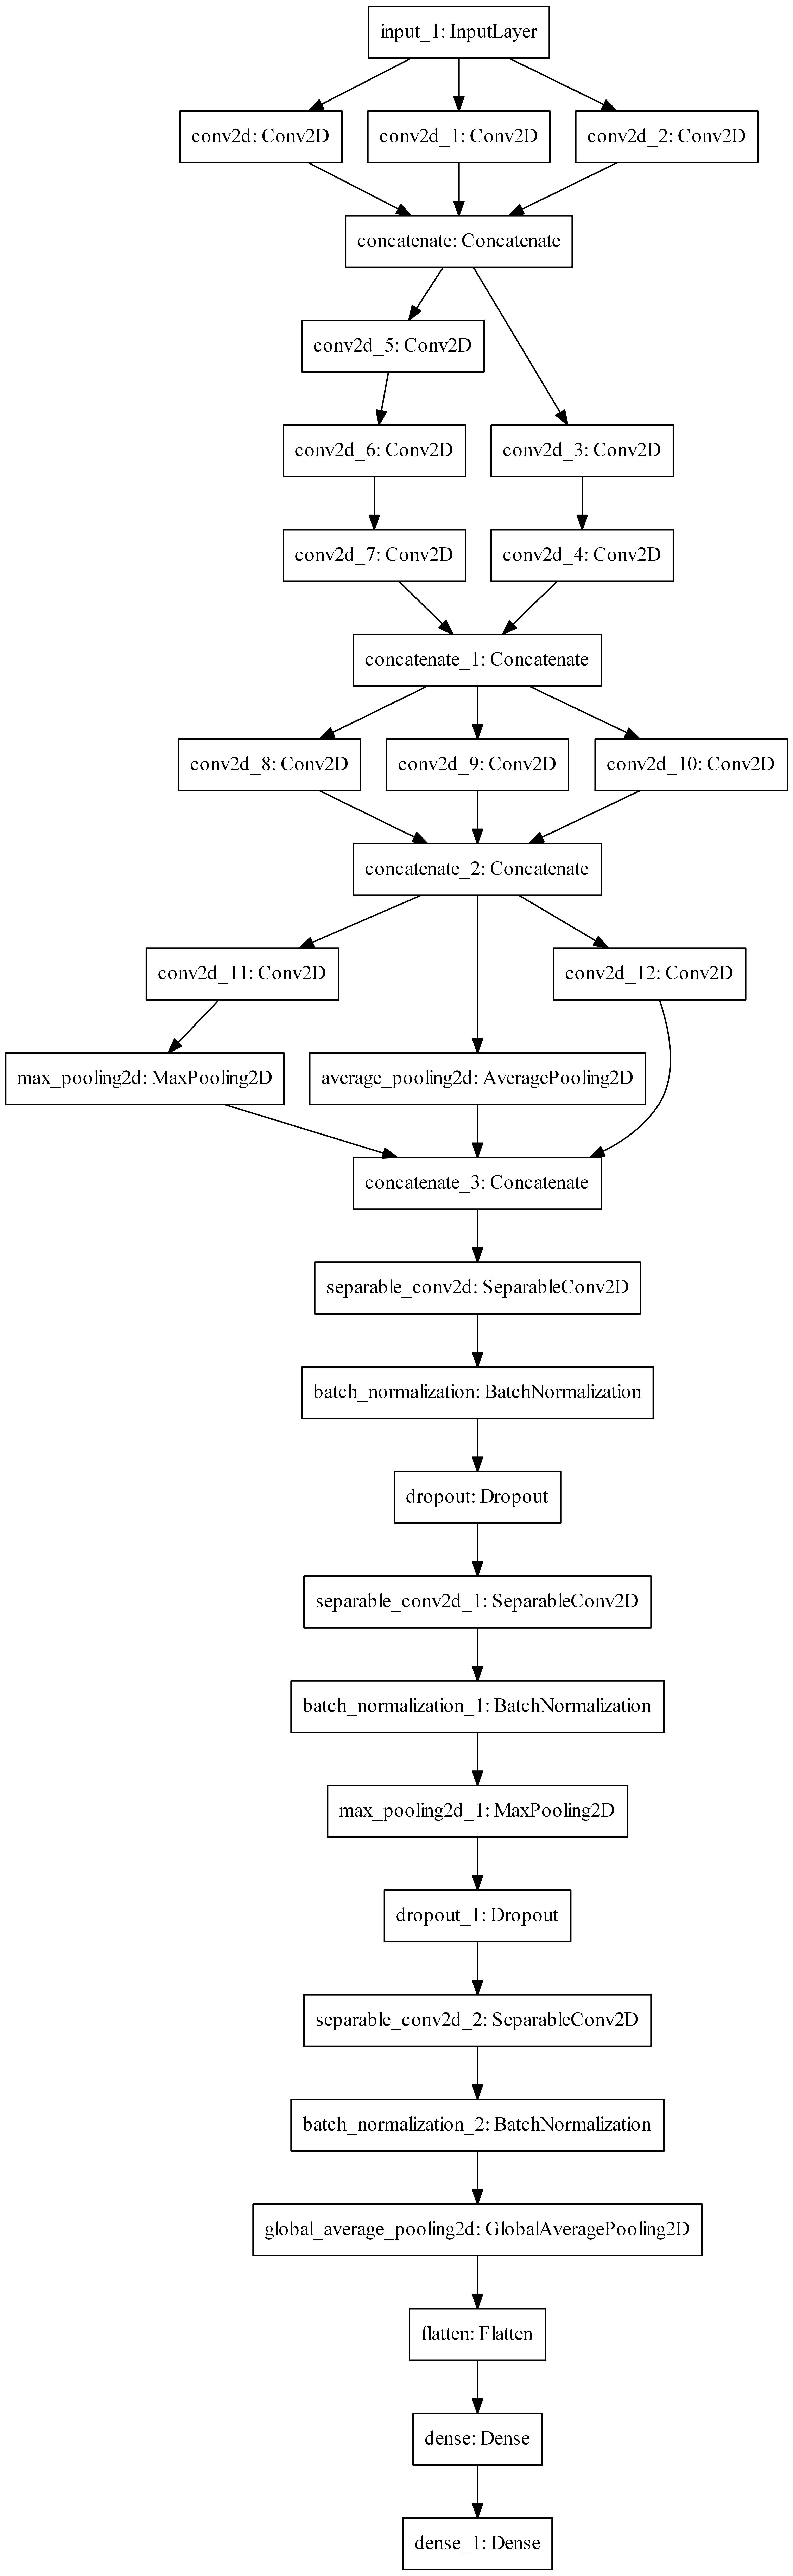

In [12]:
tf.keras.utils.plot_model(
    model, to_file=model_name+'.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=500)

# Оценка

In [10]:
label_map = (train_data_gen.class_indices)
print(label_map)

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


In [11]:
model.evaluate_generator(test_data_gen, verbose = 1)

968/968 [==============================] - 14s 14ms/step - loss: 0.0954 - acc: 0.9700


[0.09541468304916902, 0.97004133]

In [12]:
def test_generator (image_size,  test_path):
   
    test_labels=[]
    test_data = []
        
    for i in [ '\\NORMAL\\', '\\DME\\', '\\DRUSEN\\', '\\CNV\\']:
        
        for img in (os.listdir(os.path.join(test_path + i))):
            
            img = image.load_img(test_path + i + img, grayscale = True, target_size=(IMG_HEIGHT, IMG_WIDTH)) 
            img_tensor = image.img_to_array(img) 
             
            img_tensor /= 255
            
            if i=='\\CNV\\':
                label = 0
            elif i=='\\DME\\':
                label = 1
            elif i=='\\DRUSEN\\':
                label = 2
            elif i=='\\NORMAL\\':
                label = 3
            
            test_data.append(img_tensor)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return  test_data, test_labels

In [13]:
b,c=test_generator(IMG_HEIGHT, test_dir)

In [14]:
test_data_gen.reset()
y_pred = model.predict(b)
Y_pred = np.argmax(y_pred, axis=-1)

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

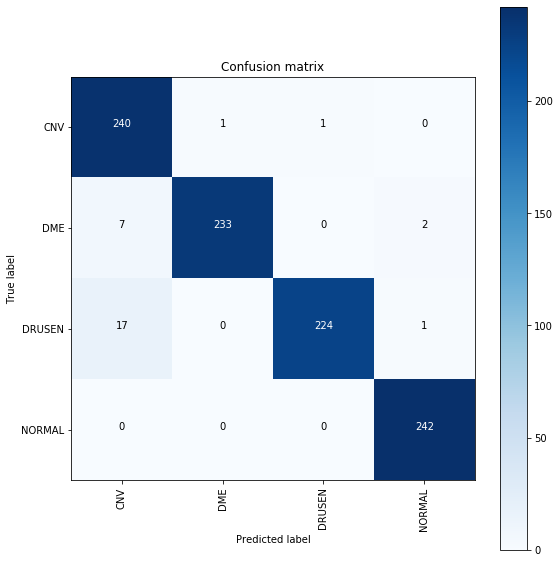

In [16]:
cm = confusion_matrix(c, Y_pred)
 
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=['CNV','DME','DRUSEN','NORMAL'], normalize=False, 
                      title='Confusion matrix', cmap = plt.cm.Blues)
plt.show()

In [17]:
from sklearn.metrics import classification_report
print(classification_report(c,Y_pred,target_names=['CNV','DME','DRUSEN','Normal']))

precision    recall  f1-score   support

         CNV       0.91      0.99      0.95       242
         DME       1.00      0.96      0.98       242
      DRUSEN       1.00      0.93      0.96       242
      Normal       0.99      1.00      0.99       242

    accuracy                           0.97       968
   macro avg       0.97      0.97      0.97       968
weighted avg       0.97      0.97      0.97       968



# Карты активации

In [12]:
def activation_maps(img_class):
    return os.path.join(test_dir, str(img_class), random.choice(os.listdir(os.path.join(test_dir, str(img_class)))))

Исходное изображение 
 
 DME


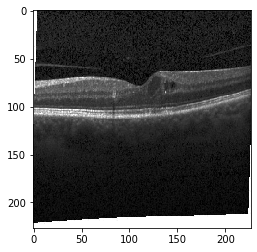

In [14]:
def activation_maps(img_class):
    return os.path.join(test_dir, str(img_class), random.choice(os.listdir(os.path.join(test_dir, str(img_class)))))

imgs = {'NORMAL': activation_maps('NORMAL'), 'CNV': activation_maps('CNV'), 'DME': activation_maps('DME'), 'DRUSEN': activation_maps('DRUSEN')}

a = input('Введите один из 4 классов:'+ '\n'+' DME, CNV, DRUSEN, NORMAL ').upper()

img_path = imgs[a]

img = image.load_img(img_path, grayscale = True, target_size=(IMG_HEIGHT, IMG_WIDTH)) 
img_tensor = image.img_to_array(img) 
img_tensor = np.expand_dims(img_tensor, axis=0) 
img_tensor /= 255

plt.imshow(img_tensor.reshape(227,227), cmap = 'gray') 
print('Исходное изображение','\n','\n', a)

plt.show()

In [15]:
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name or 'concatenate' in layer.name]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]

print('Размер карты активации: ' + str(first_layer_activation.shape)) 

Размер карты активации: (1, 227, 227, 16)


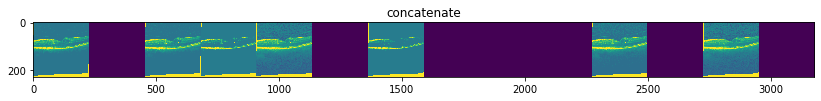

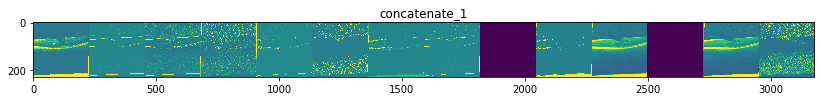

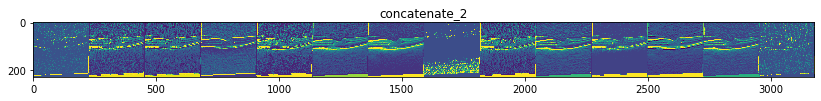

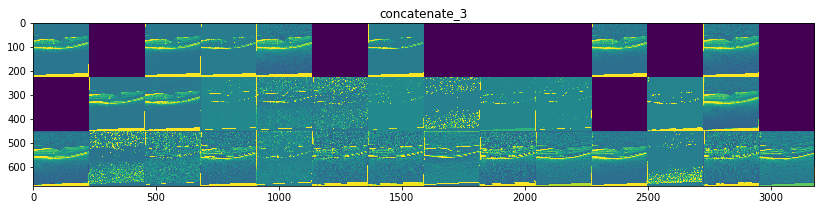

In [22]:
layer_names = [] 
for layer in model.layers:
    if 'concatenate' in layer.name:
        layer_names.append(layer.name)
images_per_row = 14 
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row     
    display_grid = np.zeros((size * n_cols, images_per_row * size))
 
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]            
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size    
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.imsave(model_name +'_'+ layer_name+'.png',display_grid)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Тепловая карта активации

Класс:  CNV 

Тепловая карта активации: 



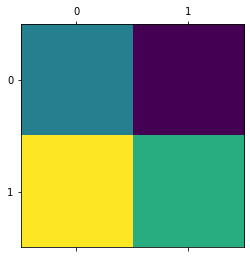

In [14]:
layer_names = [] 
for layer in model.layers:
    if 'conv' in layer.name :#or 'concatenate' in layer.name:
        layer_names.append(layer.name)

preds = model.predict(img_tensor)

np.argmax(preds[0])

label_map = (train_data_gen.class_indices)

for i,j in label_map.items():
    if j == np.argmax(preds[0]):
        class_name = i
        print('Класс: ',i,'\n')

drus = model.output[:,np.argmax(preds[0])]

last_conv_layer = model.get_layer(layer_names[-1])

grads = K.gradients(drus,last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2)) 

iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

for i in range(448):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

heatmap = np.maximum(heatmap, 0) 
heatmap /= np.max(heatmap) 
print('Тепловая карта активации:','\n')
plt.matshow(heatmap)

In [32]:
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('C:/Users/dmtry/Desktop/' + 'incep' + str(class_name) + '.jpg', superimposed_img)

True